# Pairs Trading Strategy
### Author: Ong Shao Yong, October 2024
Pairs Trading is a well known quantitative trading strategy used by many investors. This is a market neutral strategy where traders hedge against market movements by taking advantage of mean-reversion behavior between a pair of assets (Fallahpour et al., 2016). It consists of several approaches, including the distance, cointegration and time series approaches. This project will focus on the cointegration approach. (Krauss, 2017)

In order to reliably predict price movements of these assets, we must first ensure that a stationary relationship exists. Studies of non-stationary time series would make its results inapplicable outside of the given time period (Jalil & Rao, 2019). A time series is stationary if its statistical properties do not change over time. This implies that the series reverts to a constant mean and has a constant variance, which is what the Pairs Trading strategy takes advantage of. In the case of pairs trading, the spread between the two assets is the stationary relationship.

Cointegration is a "general concept for describing a stationary relationship between non-stationary variables" (Jalil & Rao, 2019), implying that the linear combination of two (or more) nonstationary variables could be stationary with a stable long term relationship. For the purpose of pairs trading, this relationship that we focus on is the spread. In other words, two assets are said to be cointegrated if we can prove that their spread is stationary.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


We will use two cryptocurrencies that have historically been correlated in their price movements - Bitcoin (BTC) and ETH (Ethereum).

In [2]:
# BTC vs ETH
tickers = ['BTC-USD', 'ETH-USD']
data = yf.download(tickers, start='2018-01-01', end='2024-01-01')['Adj Close']
print(data.head())
print(data.describe())

[*********************100%%**********************]  2 of 2 completed
                 BTC-USD     ETH-USD
Date                                
2018-01-01  13657.200195  772.640991
2018-01-02  14982.099609  884.443970
2018-01-03  15201.000000  962.719971
2018-01-04  15599.200195  980.921997
2018-01-05  17429.500000  997.719971
            BTC-USD      ETH-USD
count   2191.000000  2191.000000
mean   21758.150358  1255.187957
std    16009.616698  1125.533518
min     3236.761719    84.308296
25%     8321.381348   228.654282
50%    17034.292969  1086.519287
75%    32156.772461  1870.897217
max    67566.828125  4812.087402


# Cointegration Test

To prove that the two assets are indeed cointegrated, we perform an Engel-Granger Cointegration test. This is done through the following steps (Krauss, 2017):

1. Peform Ordinary Least Square (OLS) regression of Stock 1 (BTC) on Stock 2 (ETH)

$$
\text{stock1}_t = \beta \cdot \text{stock2}_t + \epsilon_t\
$$ 
<br>

2. Obtain residuals (spread) of the regression

$$
\epsilon_t = \text{stock1}_t - (\beta \cdot \text{stock2}_t)\
$$
<br>

3. Using a test for stationarity, check if the resulting spread is stationary. We choose the Augmented Dickey-Fuller (ADF) hypothesis test for this purpose (5% level of significance).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ADF Test Equation: 
$$ \Delta \epsilon_t = \gamma \epsilon_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta \epsilon_{t-i} + \nu_t (noise)$$

$$
H_0: \gamma = 0 \quad \text{(The residual/spread is non-stationary; p-value > 0.05)} \\
H_1: \gamma < 0 \quad \text{(The residual/spread is stationary; p-value < 0.05)}
$$


NOTE: The Engel-Granger test generally fails to capture more than one cointegration. However, since we are dealing with a bivariate model, the test is applicable.

In [3]:
# Test for cointegration: Augmented Dickey-Fuller test on residuals (spread) of both assets
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def checkCointegration(asset1, asset2):
    stock2_with_const = sm.add_constant(asset2)
    result = sm.OLS(asset1, stock2_with_const).fit()
    
    b = result.params[1]
    residuals = asset1 - b * asset2 
    result = adfuller(residuals)
    
    return result[1]

asset1 = data.iloc[:, 0]
asset2 = data.iloc[:, 1]
asset1_name = data.columns[0]
asset2_name = data.columns[1]
p_value = checkCointegration(asset1, asset2)

# Hypothesis test
if p_value < 0.05:
    print("%s and %s are cointegrated (p-value: %.4f)" % (asset1_name, asset2_name, p_value))
else:
    print("%s and %s are not cointegrated (p-value: %.4f)" % (asset1_name, asset2_name, p_value))



BTC-USD and ETH-USD are cointegrated (p-value: 0.0148)


In [4]:
# Explore correlation
correlation = asset1.corr(asset2)
print("Correlation of %s and %s: %.4f" % (asset1_name, asset2_name, correlation))

Correlation of BTC-USD and ETH-USD: 0.9238


# Calculating Asset Spread

With the same OLS method used in our cointegration test, we obtain the adjusted spread of the assets.

In [5]:
# Step 3: Calculate the spread
def getSpread(asset1,asset2):
    asset2_with_const = sm.add_constant(asset2)
    result = sm.OLS(asset1, asset2_with_const).fit()

    b = result.params[1]
    spread = asset1 - b * asset2 
    mean_spread = spread.mean()
    std_spread = spread.std()
    return spread, mean_spread, std_spread, b

spread, mean_spread, std_spread, b = getSpread(asset1, asset2)
print("Mean Spread: %.4f" % mean_spread)
print("Std Deviation of Spread: %.4f" % std_spread)



Mean Spread: 5264.7717
Std Deviation of Spread: 6129.6548


# Reducing Noise

The tests for cointegration done earlier confirms that the spread is generally mean reverting. However, in shorter time frames, high periods of volatility could cause the patterns to shift momentarily and result in higher losses (Chang et al., 2018). To mitigate this risk, we use moving averages instead of daily prices for analysis.

**Short Term Moving Average** - Moving average of price in the range of 5-20 days. We will start our initial analysis with 5. <br>
**Long Term Moving Average** - Moving average of price in the range of 50-100 days. We will start our initial analysis with 50. <br>
**Z-Score** - standardise the spread by calculating the Z-Score using the following formula, allowing us to view the spread in terms of number of standard deviations from the mean:
$$\mathcal{z}_{i}=\frac{x_{i}-\mu_{i}}{\sigma} $$

Where:
- $x_{i}$ is the short term moving average
- $\mu_{i}$ is the long term moving average
- $\sigma$ is the standard deviation of the long term moving average $\mu_{i}$

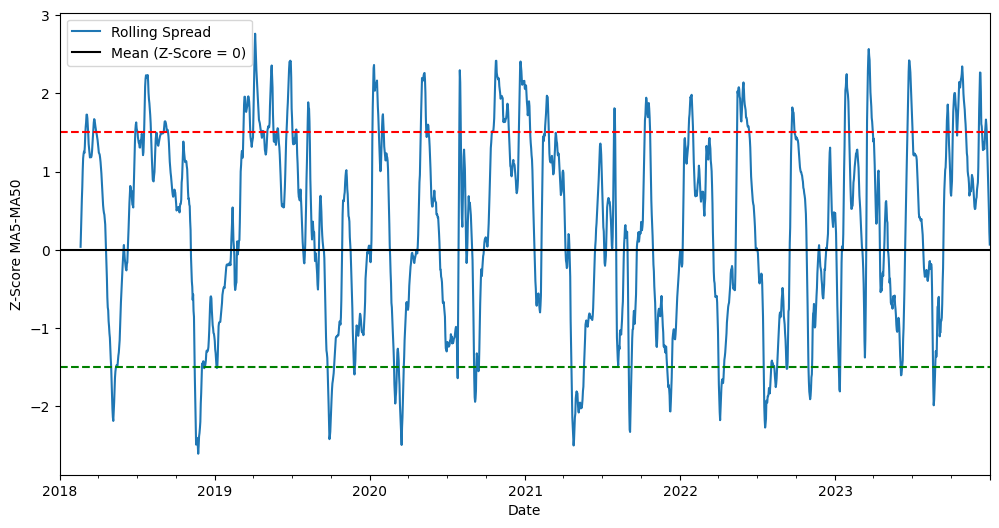

In [6]:
ma5 = spread.rolling(window=5).mean()
ma50 = spread.rolling(window=50).mean()
std_50 = spread.rolling(window=50).std()
zscore = (ma5 - ma50)/std_50
plt.figure(figsize=(12,6))
zscore.plot()
plt.axhline(0, color='black')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Rolling Spread', 'Mean (Z-Score = 0)'])
plt.ylabel('Z-Score MA5-MA50')
plt.show()

From the graph, it is observed that the rolling spread is generally mean reverting, and tends to revert to the mean when the time series moves 1.5 standard deviations away.

# Trading Strategy

With this knowledge of the mean reverting behavior, we can craft our trading strategy using a combination of moving averages and z-scores to generate buy and sell signals. The goal is to take advantage of the relative price movements between the two assets by buying one asset and simultaneously selling the other when the spread deviates significantly from its historical average.

## Key Steps
1. Moving Average Calculation:

- Two moving averages of the spread between BTC and ETH are calculated: a short-term moving average and a long-term  moving average.
- Normalized the spread by its standard deviation to derive Z-score.

2. Buy and Sell Signal Generation:

- A buy signal is triggered when the z-score falls below a predefined negative threshold (i.e., the spread has narrowed too much). Based on the exploratory data analysis above, we choose 1.5 as the threshold.
- A sell signal is triggered when the z-score rises above the same positive threshold (i.e., the spread has widened too much).

3. Trade Execution:

- When a buy signal is triggered, the strategy buys BTC and sells ETH (long the spread).
- When a sell signal is triggered, the strategy sells BTC and buys ETH (short the spread).

4. Return Calculation:

- The strategy calculates the returns based on the difference between the buy and sell prices for each trade.
- Returns are computed as a percentage of the initial buy price.

5. Performance Metrics:

- The expected return is calculated as the mean return of all trades.
- The volatility is calculated as the standard deviation of returns.
- The Sharpe ratio is computed as the ratio of expected return to volatility, providing a measure of risk-adjusted performance.

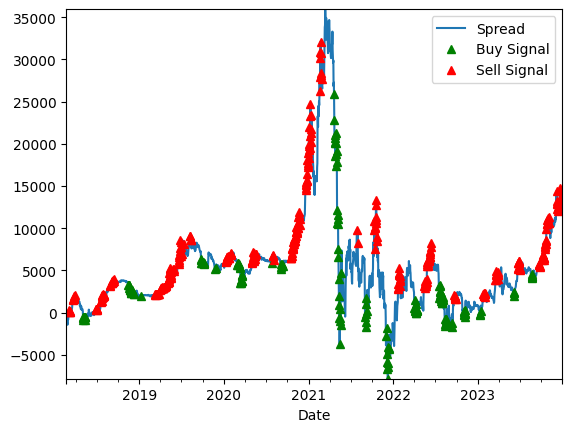

<Figure size 1200x700 with 0 Axes>

In [7]:
# Start from Day 60 to trade from first MA60
spread[50:].plot()
buy = spread.copy()
sell = spread.copy()
# Set non-buy/non-sell levels to 0
buy[zscore>-1.5] = 0
sell[zscore<1.5] = 0
buy[:50] = 0
sell[:50] = 0

# Plot graph
buy[buy!=0].plot(color='g', linestyle='None', marker='^')
sell[sell!=0].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, spread.min(), spread.max()))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.figure(figsize=(12,7))
plt.show()

In [8]:
# Trading strategy
def pairsTrading(asset1,asset2,spread,mashort,malong,threshold=1.5):
    # Moving Average Calculations
    spread_mavg5 = spread.rolling(window=mashort).mean()
    spread_mavg60 = spread.rolling(window=malong).mean()
    std_60 = spread.rolling(window=malong).std()
    zscore = (spread_mavg5 - spread_mavg60)/std_60

    # Buy and Sell Signals
    buy = spread.copy()
    sell = spread.copy()
    buy[zscore>-threshold] = 0
    sell[zscore<threshold] = 0

    # Buy and sell prices
    longPrices = 0*asset1.copy() 
    shortPrices = 0*asset1.copy() 

    # Buy the spread (long stock 1, short stock 2)
    longPrices[buy!=0] = asset1[buy!=0]
    shortPrices[buy!=0] = asset2[buy!=0]

    # Sell the spread (short stock 1, long stock 2)
    longPrices[sell!=0] = asset2[sell!=0]
    shortPrices[sell!=0] = asset1[sell!=0]

    buy_prices = longPrices[longPrices != 0]
    sell_prices = shortPrices[shortPrices != 0]
    num_trades = min(len(buy_prices), len(sell_prices))
    raw_return = (sell_prices[:num_trades].values - buy_prices[:num_trades].values)
    percent_returns = (sell_prices[:num_trades].values - buy_prices[:num_trades].values) / buy_prices[:num_trades].values # percentage returns

    # Expected return (mean return over all trades)
    expected_return = np.mean(raw_return)

    # Standard deviation of the returns (volatility)
    volatility = np.std(percent_returns)

    # Sharpe ratio = (Expected Return) / Volatility
    sharpe_ratio = np.mean(percent_returns) / volatility


    return raw_return, percent_returns, expected_return, sharpe_ratio

train_return, train_percent_returns, train_expected_return, train_sharpe_ratio = pairsTrading(asset1, asset2, spread, 5, 50, 1.5)
print("\nTraining Data")

print("Total positions: %d" % len(train_percent_returns))
print("Total trading days: %d" % len(asset1))
print("Total Returns : ${:,.2f}".format(train_return.sum()))
print("Return on Investment (ROI): %.2f%%" % train_percent_returns.mean())
print(f"Expected Return (per trade of 1 unit each): {train_expected_return:.4f}")
print(f"Sharpe Ratio: {train_sharpe_ratio:.4f}")



Training Data
Total positions: 613
Total trading days: 2191
Total Returns : $3,723,195.69
Return on Investment (ROI): 16.84%
Expected Return (per trade of 1 unit each): 6073.7287
Sharpe Ratio: 1.1029


# Tuning Parameters

With our function, we can then attempt to find the optimal entry and exit thresholds, as well as the ideal moving average time frame (i.e Number of standard deviations from mean) for our algorithm. From our previous gauge of the plot, a value of 1.5 was selected, with 5 day and 50 day moving averages selected, but this might not be the optimal value.

Since we are tuning three parameters in a relatively small range, a simple Grid Search algorithm can be applied to find the optimal MA and threshold values. In this case, we will be maximizing the Sharpe ratio as we focus on achieving a more consistent and risk-adjusted strategy.

In [9]:
best_sharpe = -np.inf
best_threshold = None
best_raw_return = None
best_percent_returns = None
best_expected_return = None
best_mashort = None
best_malong = None
threshold_range = np.arange(0.5, 1.5, 0.1)
ma_short_range = np.arange (5,10,1)
ma_long_range = np.arange (50,100,10)

for mashort in ma_short_range:
    for malong in ma_long_range:
        for i in threshold_range:
            raw_return, percent_returns, expected_return, sharpe_ratio = pairsTrading(asset1, asset2, spread,mashort,malong, i)     
            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_threshold = i
                best_raw_return = raw_return
                best_percent_returns = percent_returns
                best_expected_return = expected_return
                best_mashort = mashort
                best_malong = malong

print("Total positions: %d" % len(best_percent_returns))
print("Total trading days: %d" % len(asset1))
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best Sharpe Ratio: {best_sharpe:.4f}")
print(f"Best PnL: {best_expected_return}")
print("Return on Investment (ROI): %.2f%%" % best_percent_returns.mean())
print(f"Best Short Term MA: {best_mashort}")
print(f"Best Long Term MA: {best_malong}")


Total positions: 727
Total trading days: 2191
Optimal Threshold: 1.4000
Best Sharpe Ratio: 1.2740
Best PnL: 8660.604032199026
Return on Investment (ROI): 18.09%
Best Short Term MA: 9
Best Long Term MA: 90


In [10]:
raw_return, percent_returns, expected_return, sharpe_ratio = pairsTrading(asset1, asset2, spread, best_mashort, best_malong, best_threshold)

# Display total returns, expected returns, and Sharpe ratio
print("Total positions: %d" % len(percent_returns))
print("Total trading days: %d" % len(asset1))
print("Total Returns: ${:,.2f}".format(raw_return.sum()))
print("Return on Investment (ROI): %.2f%%" % percent_returns.mean())
print(f"Expected Return (per trade of 1 unit each): {expected_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")



Total positions: 727
Total trading days: 2191
Total Returns: $6,296,259.13
Return on Investment (ROI): 18.09%
Expected Return (per trade of 1 unit each): 8660.6040
Sharpe Ratio: 1.2740


# Backtesting

We have proved that this strategy is profitable for trading the BTC-ETH spread. To ensure that our strategy works with other pairs of assets, we will test it on another pair of cointegrated equities. MasterCard (MA) and Visa (V)were chosen for this purpose.

In [11]:
tickers = ['MA', 'V']
data = yf.download(tickers, start='2018-01-01', end='2024-01-01')['Adj Close']
asset1_test = data.iloc[:, 0]
asset2_test = data.iloc[:, 1]
asset1_test_name = data.columns[0]
asset2_test_name = data.columns[1]
p_value = checkCointegration(asset1, asset2)

# Hypothesis test
if p_value < 0.05:
    print("%s and %s are cointegrated (p-value: %.4f)" % (asset1_test_name, asset2_test_name, p_value))
else:
    print("%s and %s are not cointegrated (p-value: %.4f)" % (asset1_test_name, asset2_test_name, p_value))
    
spread, mean_spread, std_spread, b = getSpread(asset2_test, asset2_test)

new_return, test_percent_returns, test_expected_return, test_sharpe_ratio = pairsTrading(asset1_test, asset2_test, spread, best_mashort, best_malong, best_threshold)
print("Total positions: %d" % len(test_percent_returns))
print("Total trading days: %d" % len(asset1_test))
print("Total Returns: ${:,.2f}".format(new_return.sum()))
print("Return on Investment (ROI): %.2f%%" % test_percent_returns.mean())
print(f"Expected Return (per trade of 1 unit each): {test_expected_return:.4f}")
print(f"Sharpe Ratio: {test_sharpe_ratio:.4f}")

[*********************100%%**********************]  2 of 2 completed
MA and V are cointegrated (p-value: 0.0148)
Total positions: 372
Total trading days: 1509
Total Returns: $-7,713.02
Return on Investment (ROI): 0.04%
Expected Return (per trade of 1 unit each): -20.7339
Sharpe Ratio: 0.0983


From these results, our strategy produces positive results for the pair of Mastercard-Visa as well.

# Kelly Criterion

As seen above, the pairs trading strategy produces profitable results for both our training and backtest set. However, we can further optimise this by adjusting position sizing based on the Kelly Criterion, allowing us to encapsulate factors such as  bankroll and risk of ruin. We use the continuous Kelly Criterion to determine this sizing (Davis & Lleo, 2013) with the following formula:
$$f^* = \frac{S}{\sigma} =\frac{\mu - r}{\sigma^2} $$ 
Where:
- $f^*$ is the fraction of the bankroll to risk
- $S$ is the expected Sharpe ratio
- $\sigma$ is the volatility (standard deviation) of returns
- $\mu$ is the expected return of the strategy
- $r$ is the risk-free return (measured by 3-Month Treasury Bond Yield)

Applying this fraction to our bankroll is known as a full Kelly strategy, which will maximize long-term growth but often leads to high volatility and large drawdowns. To combat this, fractional Kelly is often used by traders to mitgate some of this risk, reducing exposure and lowering the risk of significant capital losses to provide a more stable and manageable risk-return profile. As such, we will use the half-Kelly when implementing our strategy.


In [15]:
# r = Risk free rate (3 Month T-Bill Yield as of 21 Oct 24)
r = 0.0468

def getKelly(mean, std, r):
    return (mean - r) / std**2

std = np.std(percent_returns)
mean = np.mean(percent_returns)
r_day = np.log((1+r) ** (1/len(percent_returns)))
kelly = getKelly(mean,std,r_day)

initial_bankroll = 1_000_000
bankroll = initial_bankroll
trade_history = []
for i in percent_returns:
    # Half-Kelly
    pnl_trade = 0.5*kelly * bankroll * (i/100)
    bankroll += pnl_trade
    trade_history.append(bankroll)

roi = bankroll/initial_bankroll
print(f"Kelly Fraction: {kelly:.2f}")
print(f"Initial Bankroll: ${initial_bankroll:,.2f}")
print("Return on Investment (ROI): %.2f%%" % roi)
print(f"Final Bankroll: ${bankroll:,.2f}")



Kelly Fraction: 0.09
Initial Bankroll: $1,000,000.00
Return on Investment (ROI): 351.27%
Final Bankroll: $351,273,385.18


# Conclusion

In this project, we explored a pairs trading strategy using BTC and ETH, which returned profitable results by exploiting the spread between the two assets. By identifying buy and sell signals based on moving averages and Z-Scores, the strategy demonstrates a strong potential for generating returns. Furthermore, the implementation of the Kelly Criterion for optimal trade sizing provided a significant boost to the overall return on investment (ROI). While full Kelly offers maximum growth, we opted for half Kelly to balance risk and reward, resulting in a smoother equity curve and reduced drawdowns. 

Future work could involve exploring additional factors, such as liquidity and market volatility, to further refine the strategy and better manage risk. Due to time constraints, these factors were beyond the scope of this project.

# References

Chang, C.-L., Ilomäki, J., Laurila, H., & McAleer, M. (2018). Long Run Returns Predictability and Volatility with Moving Averages. Risks, 6(4), Article 4. https://doi.org/10.3390/risks6040105

Davis, M., & Lleo, S. (2013). Fractional Kelly Strategies in Continuous Time: Recent Developments. In L. C. MacLean & W. T. Ziemba, World Scientific Handbook in Financial Economics Series (Vol. 4, pp. 753–787). WORLD SCIENTIFIC. https://doi.org/10.1142/9789814417358_0037

Fallahpour, S., Hakimian, H., Taheri, K., & Ramezanifar, E. (2016). Pairs trading strategy optimization using the reinforcement learning method: a cointegration approach. In Soft Computing (Vol. 20, Issue 12, pp. 5051–5066). Springer Science and Business Media LLC. https://doi.org/10.1007/s00500-016-2298-4

Jalil, A., & Rao, N. H. (2019). Chapter 8—Time Series Analysis (Stationarity, Cointegration, and Causality). In B. Özcan & I. Öztürk (Eds.), Environmental Kuznets Curve (EKC) (pp. 85–99). Academic Press. https://doi.org/10.1016/B978-0-12-816797-7.00008-4

Krauss, C. (2017). Statistical Arbitrage Pairs Trading Strategies: Review and Outlook. Journal of Economic Surveys, 31(2), 513–545. https://doi.org/10.1111/joes.12153

